In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sainomore import Elissabeth, data
from sainomore.elissabeth import Weighting
from sainomore.lightning import TokenPredictionModule

In [2]:
x, y = data.long_lookup(1000, 25, 5, False)

In [3]:
class MyElissabeth(Elissabeth):
    """Elissabeth without residual stream and the output is
    subtracted by a shifted version of the input."""

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.config("input_type") == "token":
            input_ = self.embedding(x)
            x = input_
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        logits = x - torch.nn.functional.pad(input_[:, :-1], (0, 0, 1, 0))
        return torch.swapaxes(logits, 1, 2)

In [4]:
alpha = 50
config = {
    "context_length" : "25",
    "input_vocab_size" : "5",
    "d_hidden" : "5",
    "n_layers" : "1",
    "layer_norm" : "False",

    "n_is" : "1",
    "length_is" : "2",
    "d_values" : "5",
    "values_2D" : "False",
    "pe_value" : "False",

    "restrict_query_key" : "False",
    "exponent": "1",
    "d_query_key": "3",

    "bias" : "False",

    "share_queries" : "False",
    "share_keys" : "False",
    "share_values" : "False",

    "distance_weighting" : "True",
    "alpha_multiplier" : f"{alpha}",
    "sum_normalization" : "False",
}
model = MyElissabeth.build(
    config,
    Weighting.RELATIVE_DISTANCE | Weighting.COSINE,
)

In [5]:
state_dict = model.state_dict()

state_dict["embedding.weight"] = torch.eye(5)
state_dict["layers.0.W_V"] = torch.Tensor([[
    [[1, 0, 0, 0, 0],
     [0, 1, 0, 0, 0],
     [0, 0, 1, 0, 0],
     [0, 0, 0, 1, 0],
     [0, 0, 0, 0, 1]],

    [[1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1],
     [1, 1, 1, 1, 1]]
]]).unsqueeze(-1)

state_dict["layers.0.W_O"] = torch.Tensor([[
    [1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0],
    [0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
]]).unsqueeze(2)
state_dict["unembedding.weight"] = torch.eye(5)

state_dict["layers.0.weightings.0.alpha"] = torch.Tensor([[
    [10_000, 0]
]]).unsqueeze(-1).unsqueeze(-1)

d = torch.pi / 2
state_dict["layers.0.weightings.1.W_Q"] = torch.Tensor([[
    [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [d, 0, 0], [0, d, 0], [0, 0, d], [d, d, 0]],
]])
state_dict["layers.0.weightings.1.W_K"] = torch.Tensor([[
    [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [d, 0, 0], [0, d, 0], [0, 0, d], [d, d, 0]],
]])

model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
model.attach_all_hooks()
out = (
    torch.swapaxes(model(x).detach(), 1, 2)# - torch.nn.functional.one_hot(x, 5)
)
model.release_all_hooks()

In [7]:
print(f"Score: {torch.sum(y[:, -1] == out.argmax(2)[:, -1]) / y.shape[0]}")

Score: 1.0


In [8]:
q = model.get_hook("layers.0.weightings.1", "Q").fwd.numpy()
k = model.get_hook("layers.0.weightings.1", "K").fwd.numpy()
v = model.get_hook("layers.0", "V").fwd.numpy()
iss = model.get_hook("layers.0", "iss.2").fwd.numpy()
exid = 0

In [9]:
Q = torch.Tensor(q.squeeze())
K = torch.Tensor(k.squeeze())
V = torch.Tensor(v.squeeze())
print(f"{Q.shape=}, {K.shape=}, {V.shape=}")

Q.shape=torch.Size([1000, 25, 2, 3]), K.shape=torch.Size([1000, 25, 2, 3]), V.shape=torch.Size([1000, 25, 2, 5])


In [10]:
# the_result = torch.zeros(25, 5)
# for t in range(x.shape[1]):
#     for t_2 in range(t):
#         for t_1 in range(t_2):
#             the_result[t] += (
#                   V[t_1, 0]
#                 * V[t_2, 1]

#                 * torch.cos(Q[t, 1, 0] - K[t_2, 1, 0])
#                 * torch.cos(Q[t, 1, 1] - K[t_2, 1, 1])
#                 * torch.cos(Q[t, 1, 2] - K[t_2, 1, 2])

#                 * np.exp(-alpha * (t_2 - t_1 - 1)/25)
#             )

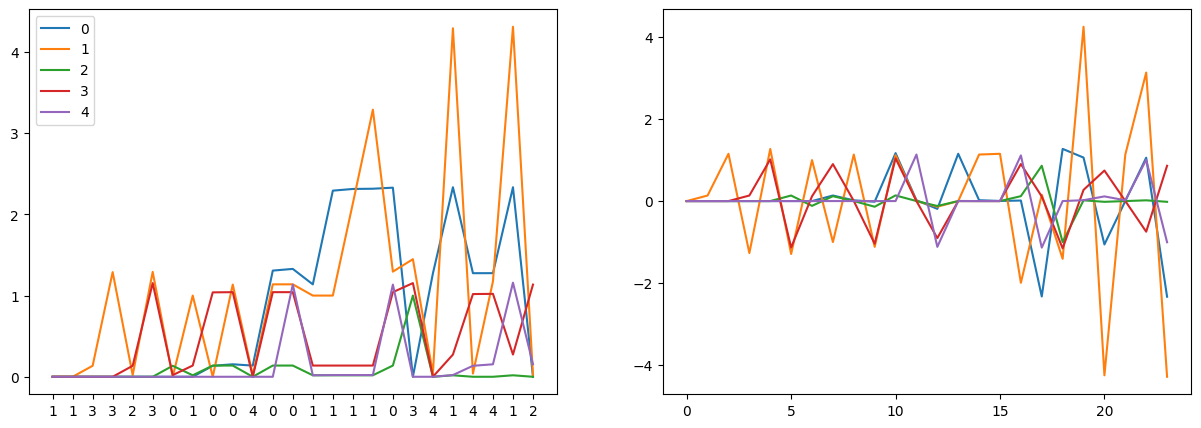

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in range(5):
    ax[0].plot(out[exid, :, i], label=f"{i}")
    ax[1].plot(out[exid, 1:, i]-out[exid, :-1, i], label=f"{i}")
ax[0].set_xticks([i for i in range(25)])
ax[0].set_xticklabels(x[exid].numpy())
ax[0].legend()

In [12]:
last_token_increase = np.zeros((x.shape[1], v.shape[-2], ))

for t in range(x.shape[1]):
    for t_2 in range(t+1):
        for t_1 in range(t_2):
            if t == x.shape[1] - 1:
                last_token_increase[t_2] = (
                    np.exp(-alpha*(1/(1+np.exp(-100)))*(t_2-t_1-1)/x.shape[1])
                    * np.cos(q[exid, t, 0, 1, 0] - k[exid, t_2, 0, 1, 0])
                    * np.cos(q[exid, t, 0, 1, 1] - k[exid, t_2, 0, 1, 1])
                    * np.cos(q[exid, t, 0, 1, 2] - k[exid, t_2, 0, 1, 2])
                    * v[exid, t_1, 0, 0, :, 0]
                )


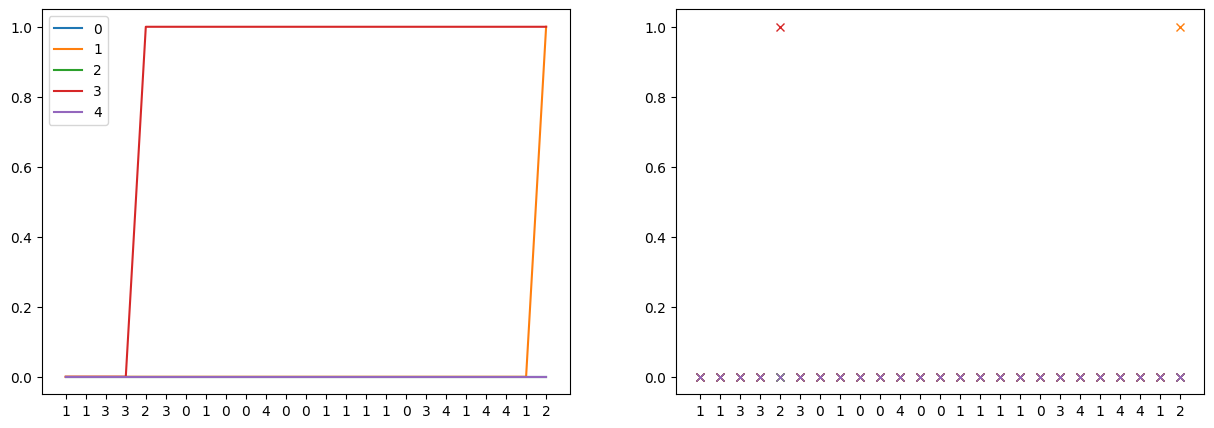

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
last_token_iss = np.cumsum(last_token_increase, axis=0)
for i in range(5):
    ax[0].plot(last_token_iss[:, i], "-", label=f"{i}")
    ax[1].plot(last_token_increase[:, i], "x", label=f"{i}")
ax[0].set_xticks([i for i in range(25)])
ax[1].set_xticks([i for i in range(25)])
ax[0].set_xticklabels(x[exid].numpy())
ax[1].set_xticklabels(x[exid].numpy())
ax[0].legend(loc="best")
plt.show()
# ax.set_yscale("log")